/usr/local/python-3.11.4/lib/python3.11/site-packages/trm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


--- Median Out-of-Eclipse Signal-to-Noise Ratios ---
CCD 1: 60.80
CCD 2: 95.29
CCD 3: 75.47
CCD 4: 75.74
CCD 5: 42.21


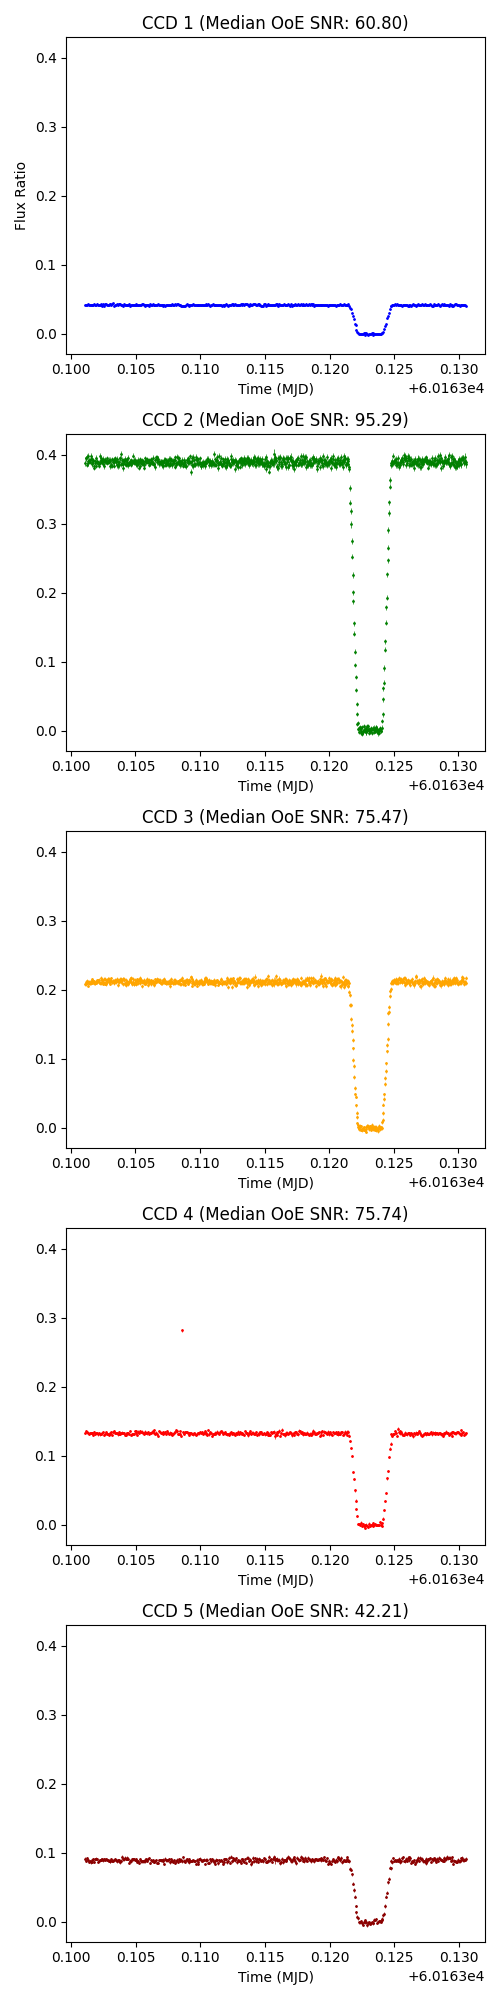

In [1]:
import matplotlib.pyplot as plt
import hipercam as hcam
import numpy as np
%matplotlib widget
hlog = hcam.hlog.Hlog.rascii('19.log')

ccd_colors = {
    '1': 'blue',
    '2': 'green',
    '3': 'orange',
    '4': 'red',
    '5': 'darkred'
}

fig, axes = plt.subplots(5, 1, figsize=(5, 20), sharey=True)

print("--- Median Out-of-Eclipse Signal-to-Noise Ratios ---")

for i in range(5):
    ccd = str(i + 1)
    color = ccd_colors[ccd]

    targ = hlog.tseries(ccd, '1')
    comp = hlog.tseries(ccd, '2')

    ratio = targ / comp

    # --- SNR CALCULATION ---
    snr_all_points = ratio.y / ratio.ye

    # Create a boolean mask to select points outside the eclipse time range.
    out_of_eclipse_mask = (ratio.t < 0.0015+6.016312e4) | (ratio.t > 0.00455+6.016312e4)

    # Calculate the MEDIAN SNR using only the out-of-eclipse data.
    # np.nanmedian to ignore any NaN values within the selected data.
    median_snr = np.nanmedian(snr_all_points[out_of_eclipse_mask])

    print(f'CCD {ccd}: {median_snr:.2f}')
    # --- END MODIFIED SNR CALCULATION ---

    ax = axes[i]
    ratio.mplot(ax, fmt='.', color=color, markersize=2, linewidth=0.5)
    ax.set_title(f'CCD {ccd} (Median OoE SNR: {median_snr:.2f})')
    ax.set_xlabel('Time (MJD)') 
    if i == 0:
        ax.set_ylabel('Flux Ratio')

plt.tight_layout()
plt.show()
plt.savefig("lightcurve.png")


CCD 1 In-Eclipse Data:
  Mean Flux: -0.000124
  Standard Deviation: 0.000661
  Number of Samples: 27
  t-statistic: -0.97
  Degrees of Freedom: 26
  P-value (one-tailed): 8.3011e-01
  Conclusion: The mean in-eclipse flux is NOT significantly above 0 (p >= 0.05).

CCD 2 In-Eclipse Data:
  Mean Flux: 0.001423
  Standard Deviation: 0.002832
  Number of Samples: 53
  t-statistic: 3.66
  Degrees of Freedom: 52
  P-value (one-tailed): 2.9764e-04
  Conclusion: The mean in-eclipse flux is significantly above 0 (p < 0.05).

CCD 3 In-Eclipse Data:
  Mean Flux: -0.000175
  Standard Deviation: 0.002263
  Number of Samples: 53
  t-statistic: -0.56
  Degrees of Freedom: 52
  P-value (one-tailed): 7.1211e-01
  Conclusion: The mean in-eclipse flux is NOT significantly above 0 (p >= 0.05).

CCD 4 In-Eclipse Data:
  Mean Flux: -0.000041
  Standard Deviation: 0.001895
  Number of Samples: 27
  t-statistic: -0.11
  Degrees of Freedom: 26
  P-value (one-tailed): 5.4400e-01
  Conclusion: The mean in-eclips

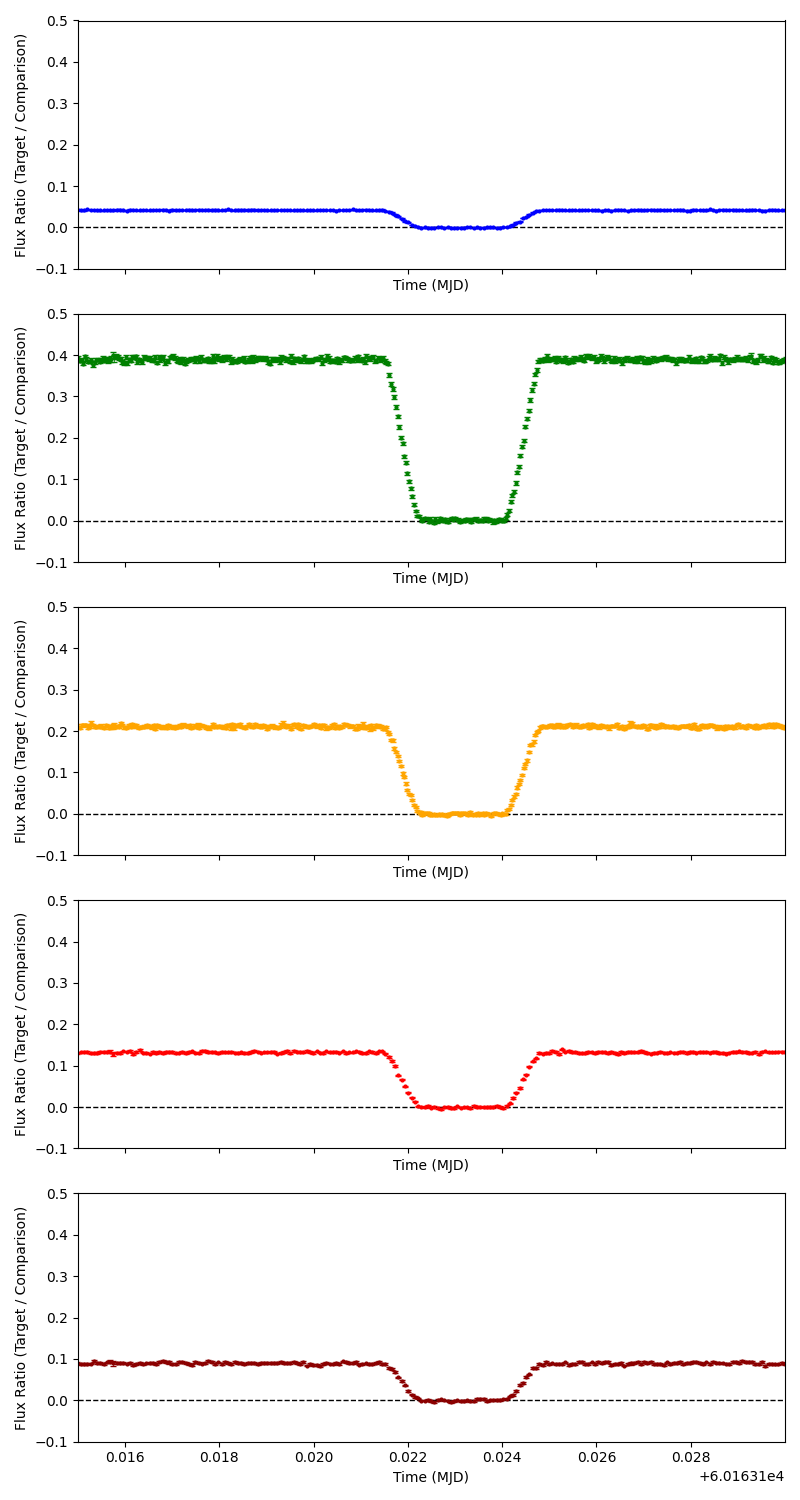

In [2]:
import matplotlib.pyplot as plt
import hipercam as hcam
import numpy as np
from scipy import stats 

hlog = hcam.hlog.Hlog.rascii('19.log')

# Define colors for each CCD
ccd_colors = {
    '1': 'blue',
    '2': 'green',
    '3': 'orange',
    '4': 'red',
    '5': 'darkred'
}

fig, axes = plt.subplots(5, 1, figsize=(8, 15), sharex=True)

for i in range(5):
    ccd = str(i + 1)
    color = ccd_colors[ccd]

    targ = hlog.tseries(ccd, '1')
    comp = hlog.tseries(ccd, '2')

    ratio = targ / comp

    in_eclipse_mask = (ratio.t > 0.00225+6.016312e4) & (ratio.t < 0.0041+6.016312e4)

    in_eclipse_flux = ratio.y[in_eclipse_mask]
    in_eclipse_error = ratio.ye[in_eclipse_mask]

    # Calculate mean, standard deviation, and number of samples for in-eclipse flux
    mean_flux = np.mean(in_eclipse_flux)
    std_dev_flux = np.std(in_eclipse_flux)
    n_samples = len(in_eclipse_flux)

    print(f"\nCCD {ccd} In-Eclipse Data:")
    print(f"  Mean Flux: {mean_flux:.6f}")
    print(f"  Standard Deviation: {std_dev_flux:.6f}")
    print(f"  Number of Samples: {n_samples}")

    # Perform a one-sample t-test to see if the mean flux is significantly above 0
    # Null Hypothesis (H0): mean_flux = 0
    # Alternative Hypothesis (H1): mean_flux > 0
    t_statistic = mean_flux / (std_dev_flux / np.sqrt(n_samples))
        
    # Degrees of freedom for a one-sample t-test
    df = n_samples - 1
        
    # Calculate the p-value for a one-tailed test (greater than 0)
    # stats.t.sf is the survival function (1 - CDF), which gives P(T > t)
    p_value = stats.t.sf(t_statistic, df)

    print(f"  t-statistic: {t_statistic:.2f}")
    print(f"  Degrees of Freedom: {df}")
    print(f"  P-value (one-tailed): {p_value:.4e}") 
    alpha = 0.05 
    if p_value < alpha:
            print(f"  Conclusion: The mean in-eclipse flux is significantly above 0 (p < {alpha}).")
    else:
            print(f"  Conclusion: The mean in-eclipse flux is NOT significantly above 0 (p >= {alpha}).")
   
    ax = axes[i]
    ratio.mplot(ax, fmt='.', color=color, markersize=4, linewidth=0.5, capsize=2)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlim(6.0163115e4, 6.0163130e4) 
    ax.set_ylim(-0.1, 0.5)
    ax.set_ylabel('Flux Ratio (Target / Comparison)')
    ax.set_xlabel('Time (MJD)')

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()
# Display the plot
plt.show()

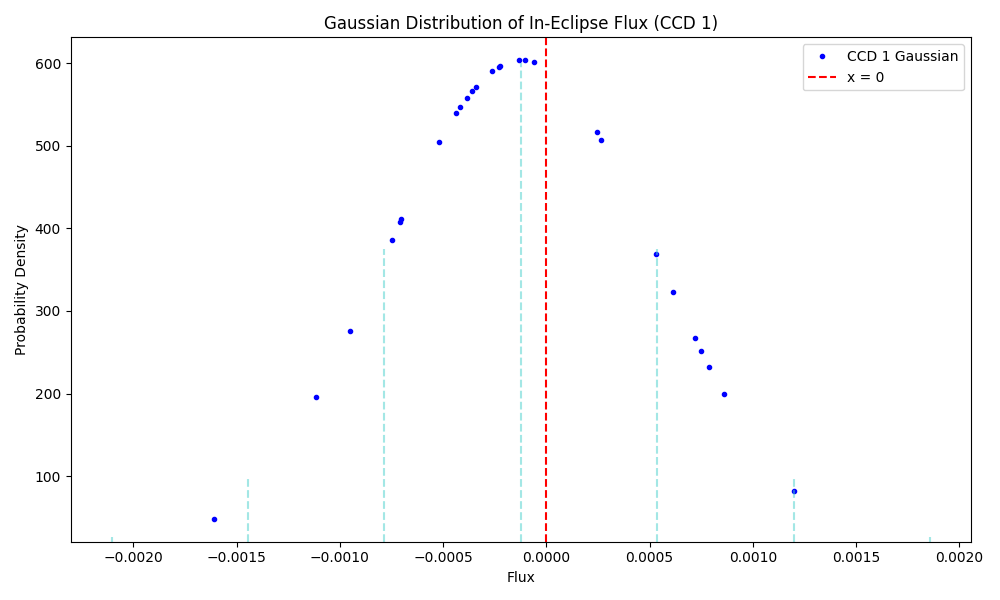

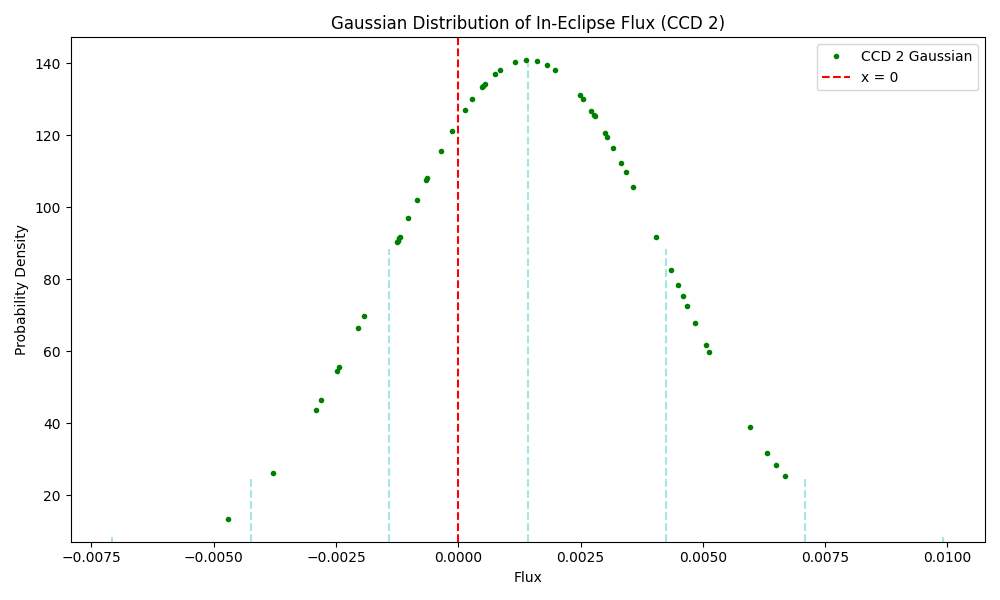

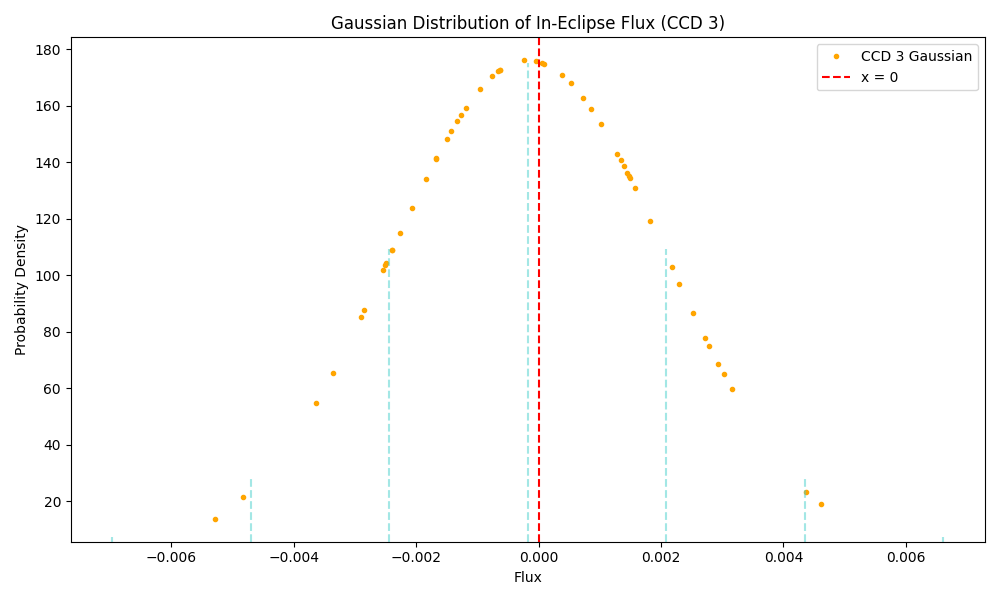

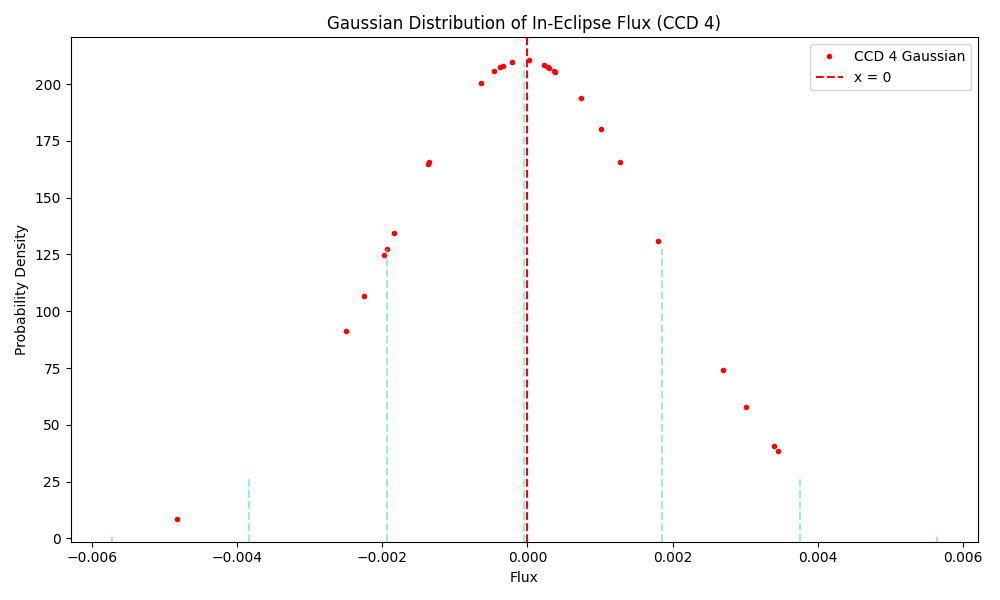

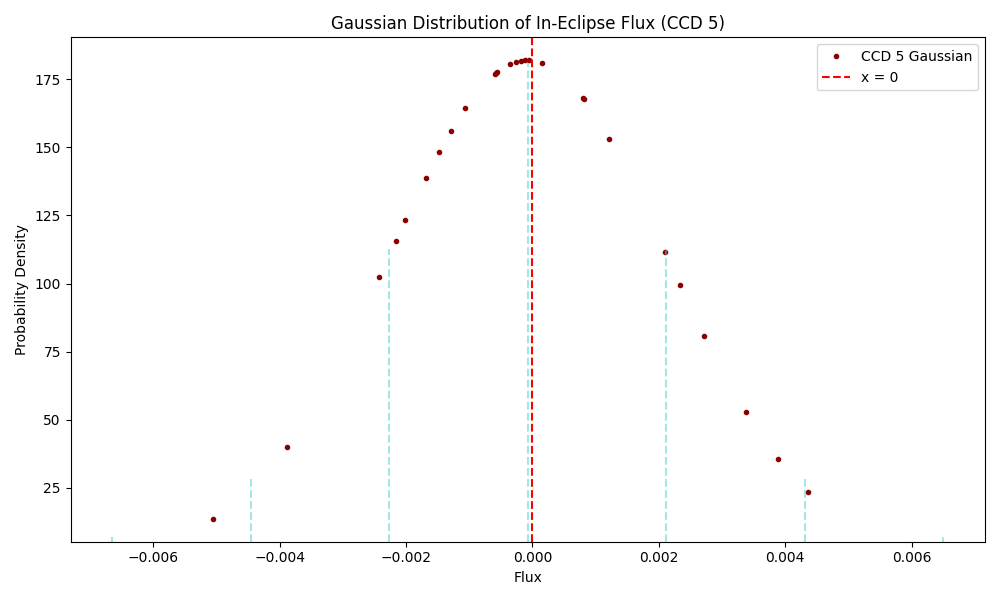

In [3]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    plt.figure(figsize=(10, 6))  # New figure for each CCD

    ccd = str(i + 1)
    color = ccd_colors[ccd]

    targ = hlog.tseries(ccd, '1')
    comp = hlog.tseries(ccd, '2')

    ratio = targ / comp

    in_eclipse_mask = (ratio.t > 0.00225 + 6.016312e4) & (ratio.t < 0.0041 + 6.016312e4)

    in_eclipse_flux = ratio.y[in_eclipse_mask]
    in_eclipse_error = ratio.ye[in_eclipse_mask]

    # Calculate mean and std dev
    mean_flux = np.mean(in_eclipse_flux)
    std_dev_flux = np.std(in_eclipse_flux)

    # Gaussian distribution values
    y = (1 / (std_dev_flux * np.sqrt(2 * np.pi))) * np.exp(
        -0.5 * ((in_eclipse_flux - mean_flux) / std_dev_flux) ** 2
    )

    # Plot Gaussian curve points
    plt.plot(in_eclipse_flux, y, '.', label=f'CCD {ccd} Gaussian', color=color)

    # Vertical lines: mean ± 1σ, 2σ, 3σ
    for n, ymax in zip(
        [-3, -2, -1, 0, 1, 2, 3],
        [0.01, 0.13, 0.58, 0.95, 0.58, 0.13, 0.01]
    ):
        plt.axvline(mean_flux + n * std_dev_flux,
                    color='mediumturquoise', linestyle='--', alpha=0.5, ymax=ymax)

    # Vertical line at x = 0
    plt.axvline(x=0, color='r', linestyle='--', label='x = 0')

    # Labels and formatting
    plt.title(f'Gaussian Distribution of In-Eclipse Flux (CCD {ccd})')
    plt.xlabel('Flux')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.tight_layout()



In [37]:
import numpy as np
import astropy.units as u
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz

lat = 28.7561 * u.deg
lon = -17.8917 * u.deg  # Longitude is West, so it's negative
# Altitude of the Roque de los Muchachos Observatory
height = 2267 * u.m 

gtc_location = EarthLocation(lat=lat, lon=lon, height=height)

hlogss = hcam.hlog.Hlog.rascii('ss1.log')
aboveatmosmag = [14.028, 13.805, 13.856, 13.995, 14.168]
for i in range(5):
    ape_number = '1' 
    standard_star_frames = hlogss.tseries(i+1, ape_number)

    airmass_values = []
    observation_times = []

    for frame, i in zip(standard_star_frames, aboveatmosmag):
        counts = frame.y
        insmag = -2.5*np.log(counts/4.86897)
        i = insmag - k*airmass_array
        obs_time = frame.t
        times = time.Time(obs_time, format='mjd', scale='utc', location=gtc_location)
        SS_coords = SkyCoord('16:28:25.0','+36:46:15', unit=(u.hourangle, u.deg), frame='icrs')
        altaz_frame = AltAz(obstime=times, location=gtc_location)

        # Transform the star's celestial coordinates (RA/Dec) to local coordinates (Alt/Az)
        SS_in_altaz = SS_coords.transform_to(altaz_frame)
    
        airmass = SS_in_altaz.secz
        airmass_values.append(airmass)
        observation_times.append(times)

        airmass_array = np.array(airmass_values)
        times_array = np.array(observation_times)

    print(airmass_array)

#instrumental magnitude of target, -2.5log(counts per second) need to divide by exposure time.

[1.0232582  1.0233085  1.0233589  1.02340938 1.02345997 1.02351065
 1.02356143 1.02361231 1.02366328 1.02371435 1.02376551 1.02381677
 1.02386813 1.02391958 1.02397114 1.02402278 1.02407453 1.02412637
 1.0241783  1.02423034 1.02428247 1.02433469 1.02438702 1.02443944
 1.02449195 1.02454457 1.02459728 1.02465009 1.02470299 1.02475599
 1.02480909]
[1.0232582  1.0233085  1.0233589  1.02340938 1.02345997 1.02351065
 1.02356143 1.02361231 1.02366328 1.02371435 1.02376551 1.02381677
 1.02386813 1.02391958 1.02397114 1.02402278 1.02407453 1.02412637
 1.0241783  1.02423034 1.02428247 1.02433469 1.02438702 1.02443944
 1.02449195 1.02454457 1.02459728 1.02465009 1.02470299 1.02475599
 1.02480909]
[1.0232582  1.0233085  1.0233589  1.02340938 1.02345997 1.02351065
 1.02356143 1.02361231 1.02366328 1.02371435 1.02376551 1.02381677
 1.02386813 1.02391958 1.02397114 1.02402278 1.02407453 1.02412637
 1.0241783  1.02423034 1.02428247 1.02433469 1.02438702 1.02443944
 1.02449195 1.02454457 1.02459728 1.

In [42]:
import numpy as np
import astropy.units as u
from astropy import time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz

lat = 28.7561 * u.deg
lon = -17.8917 * u.deg
height = 2267 * u.m 

gtc_location = EarthLocation(lat=lat, lon=lon, height=height)

hlogss = hcam.hlog.Hlog.rascii('ss1.log')
aboveatmosmag = [14.028, 13.805, 13.856, 13.995, 14.168]

instrumental_mags = []
airmass_values = []

# Loop over 5 observations
for i in range(5):
    ape_number = '1' 
    standard_star_frames = hlogss.tseries(i + 1, ape_number)

    for frame, true_mag in zip(standard_star_frames, [aboveatmosmag[i]]):
        counts = frame.y
        exposure_time = 4.86897  # Ensure this is correct for each frame

        insmag = -2.5 * np.log10(counts / exposure_time)

        obs_time = frame.t
        times = time.Time(obs_time, format='mjd', scale='utc', location=gtc_location)
        SS_coords = SkyCoord('16:28:25.0', '+36:46:15', unit=(u.hourangle, u.deg), frame='icrs')
        altaz_frame = AltAz(obstime=times, location=gtc_location)

        SS_in_altaz = SS_coords.transform_to(altaz_frame)
        airmass = SS_in_altaz.secz

        instrumental_mags.append(insmag)
        airmass_values.append(airmass.value)

# Convert to numpy arrays
instrumental_mags = np.array(instrumental_mags)
airmass_values = np.array(airmass_values)
true_mags = np.array(aboveatmosmag)

# Solve for k using linear fit
# insmag = true_mag + k * airmass => insmag - true_mag = k * airmass
delta_mags = instrumental_mags - true_mags
k, intercept = np.polyfit(airmass_values, delta_mags, 1)

print(instrumental_mags)


[-13.095727 -14.823168 -14.441189 -13.968984 -13.486308]


/tmp/ipykernel_230409/1075735736.py:48: RankWarning: Polyfit may be poorly conditioned
  k, intercept = np.polyfit(airmass_values, delta_mags, 1)



--- Results for CCD '1' (Aperture '1') ---
Extinction coefficient (k): 0.3800


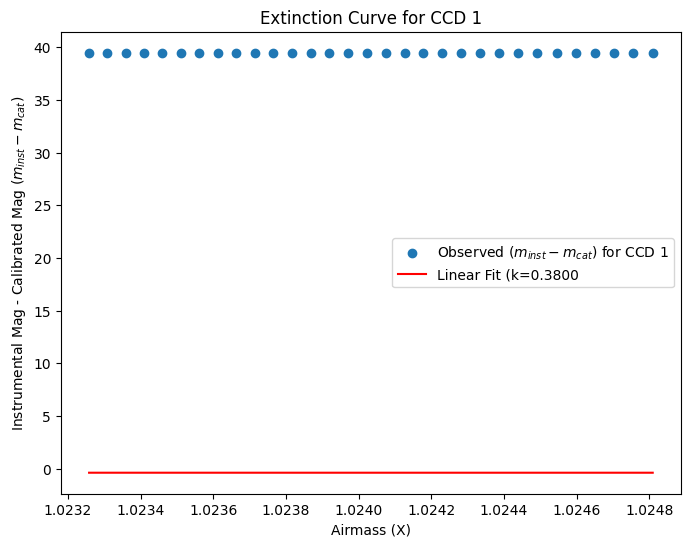


--- Results for CCD '2' (Aperture '1') ---
Extinction coefficient (k): -8.9329


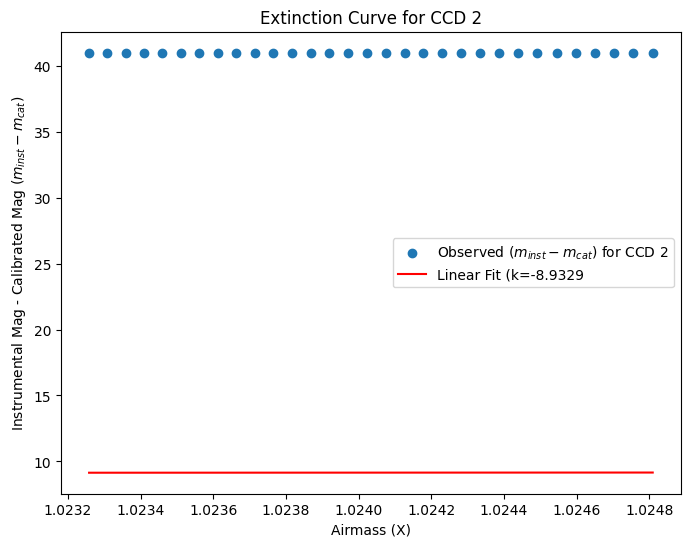


--- Results for CCD '3' (Aperture '1') ---
Extinction coefficient (k): -6.9560


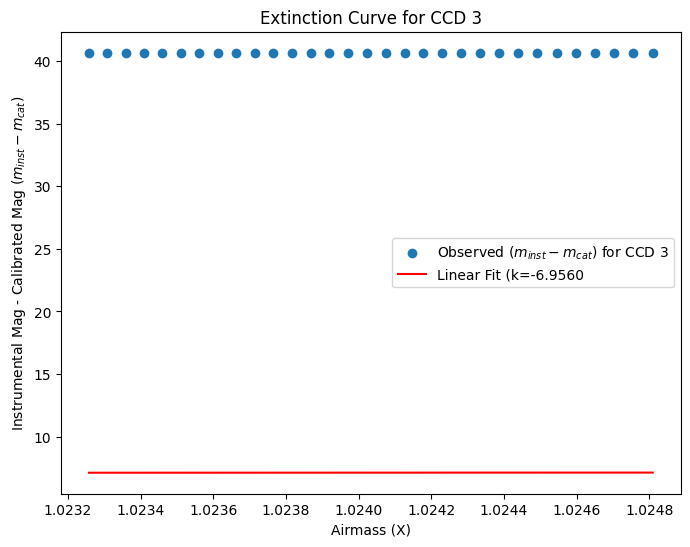


--- Results for CCD '4' (Aperture '1') ---
Extinction coefficient (k): -5.3076


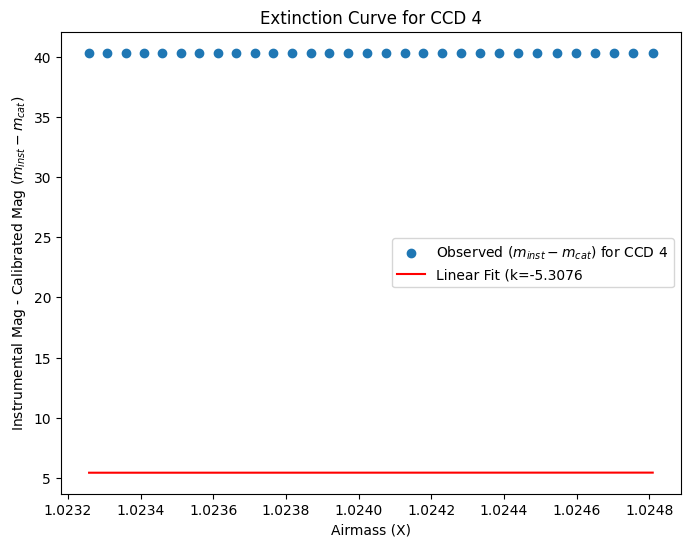


--- Results for CCD '5' (Aperture '1') ---
Extinction coefficient (k): -7.3411


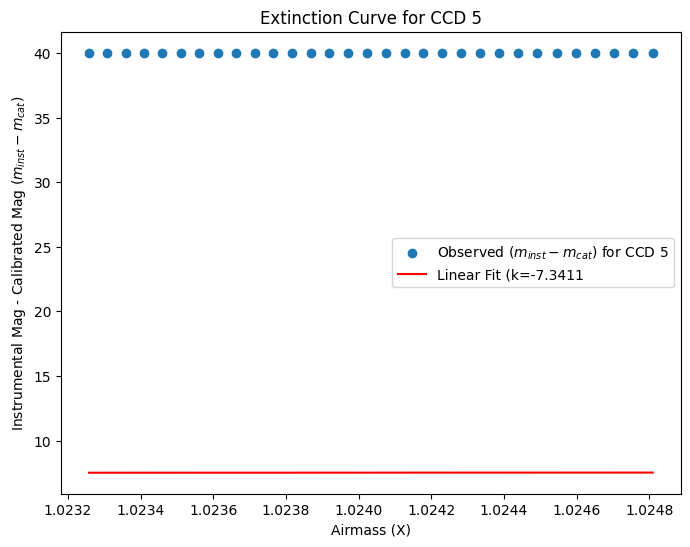

In [3]:
import numpy as np
import astropy.units as u
from astropy import time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
import hipercam as hcam
import matplotlib.pyplot as plt

# Define observatory location
lat = 28.7561 * u.deg
lon = -17.8917 * u.deg
height = 2267 * u.m
gtc_location = EarthLocation(lat=lat, lon=lon, height=height)

hlogss = hcam.hlog.Hlog.rascii('ss1.log')

# Calibrated magnitudes for each CCD
aboveatmosmag_per_ccd = [14.028, 13.805, 13.856, 13.995, 14.168]
standard_star_aperture_label = '1'
ccd_labels = sorted(hlogss.apnames.keys())

# Iterate through each CCD and its corresponding calibrated magnitude
for ccd_idx, ccd_label in enumerate(ccd_labels):

    # Lists to store data for the current CCD
    current_ccd_instrumental_mags = []
    current_ccd_airmass_values = []
    current_ccd_calibrated_mags = []

    # Get the Tseries for the current CCD and specified aperture
  
    standard_star_tseries = hlogss.tseries(ccd_label, standard_star_aperture_label)

    # Extract data from the Tseries object
    counts_data = standard_star_tseries.y
    exposure_times_data = standard_star_tseries.te
    observation_mjd_times_data = standard_star_tseries.t

    # Loop through each observation to gather data
    for j in range(len(counts_data)):
        count = counts_data[j]
        exp_time = exposure_times_data[j]
        obs_mjd_time = observation_mjd_times_data[j]

        insmag = -2.5 * np.log10(count / exp_time)

        # Calculate airmass for the current observation
        times = time.Time(obs_mjd_time, format='mjd', scale='utc')
        SS_coords = SkyCoord('16:28:25.0', '+36:46:15', unit=(u.hourangle, u.deg), frame='icrs')
        altaz_frame = AltAz(obstime=times, location=gtc_location)
        SS_in_altaz = SS_coords.transform_to(altaz_frame)
        airmass = SS_in_altaz.secz

        # Store values for linear regression
        current_ccd_instrumental_mags.append(insmag)
        current_ccd_airmass_values.append(airmass.value)


    # Convert lists to numpy arrays for the current CCD
    current_ccd_instrumental_mags = np.array(current_ccd_instrumental_mags)
    current_ccd_airmass_values = np.array(current_ccd_airmass_values)

    # Perform linear regression: m_i - m = slope * X + intercept

    delta_m_fit = aboveatmosmag_per_ccd[ccd_idx] - current_ccd_instrumental_mags
    coefficients = np.polyfit(current_ccd_airmass_values, delta_m_fit, 1)

    slope = coefficients[0]

    k = -slope  # Extinction coefficient

    print(f"\n--- Results for CCD '{ccd_label}' (Aperture '{standard_star_aperture_label}') ---")
    print(f"Extinction coefficient (k): {k:.4f}")


    # Plotting the results for the current CCD
    plt.figure(figsize=(8, 6))
    plt.scatter(current_ccd_airmass_values, delta_m_fit, label=f'Observed $(m_{{inst}} - m_{{cat}})$ for CCD {ccd_label}')
    plt.plot(current_ccd_airmass_values, slope * current_ccd_airmass_values, color='red', label=f'Linear Fit (k={k:.4f}')
    plt.xlabel('Airmass (X)')
    plt.ylabel('Instrumental Mag - Calibrated Mag ($m_{inst} - m_{cat}$)')
    plt.title(f'Extinction Curve for CCD {ccd_label}')
    plt.legend()
    plt.show()




--- Results for CCD '1' (Aperture '1') ---
Extinction coefficient (k): 0.3800
Zero point (m_zp): 39.8577


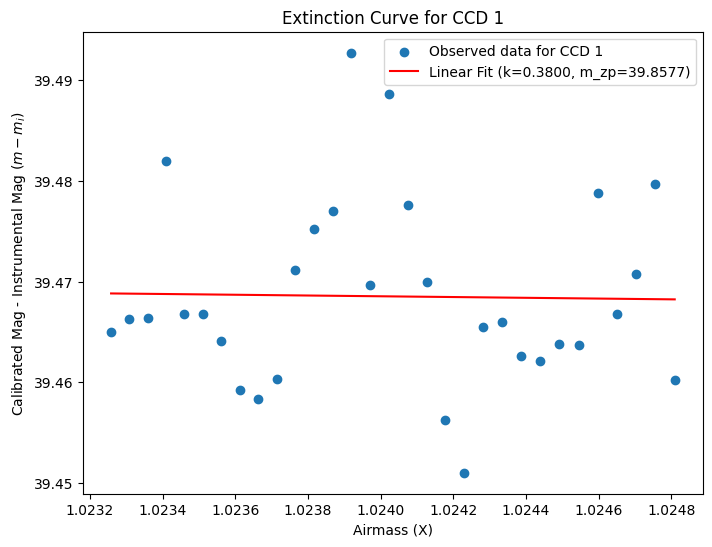


--- Results for CCD '2' (Aperture '1') ---
Extinction coefficient (k): -8.9329
Zero point (m_zp): 31.8312


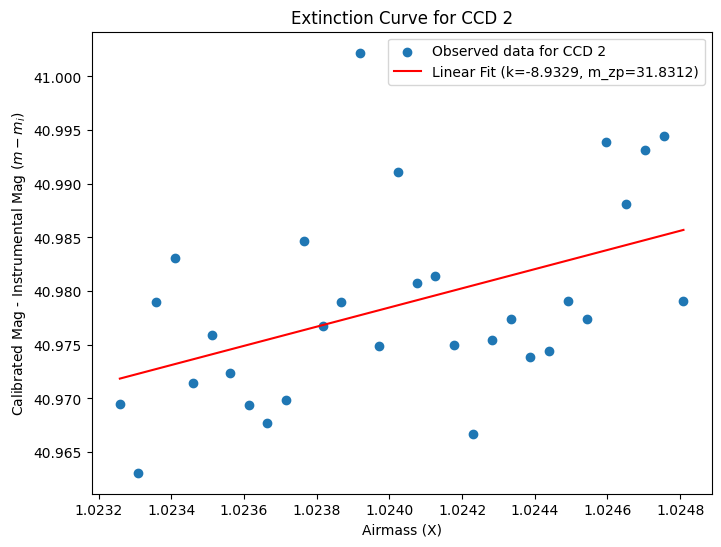


--- Results for CCD '3' (Aperture '1') ---
Extinction coefficient (k): -6.9560
Zero point (m_zp): 33.5201


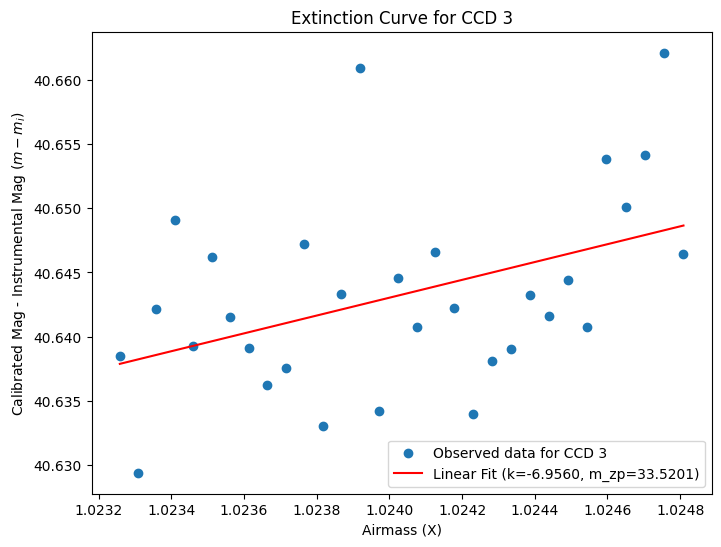


--- Results for CCD '4' (Aperture '1') ---
Extinction coefficient (k): -5.3076
Zero point (m_zp): 34.8750


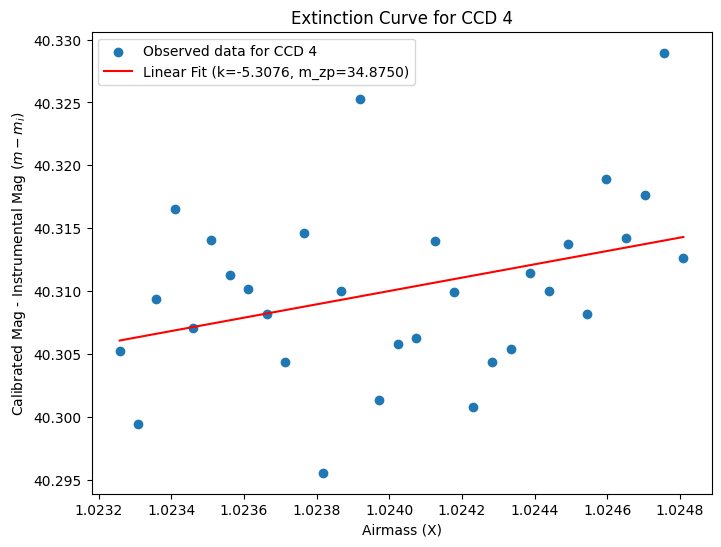


--- Results for CCD '5' (Aperture '1') ---
Extinction coefficient (k): -7.3411
Zero point (m_zp): 32.4863


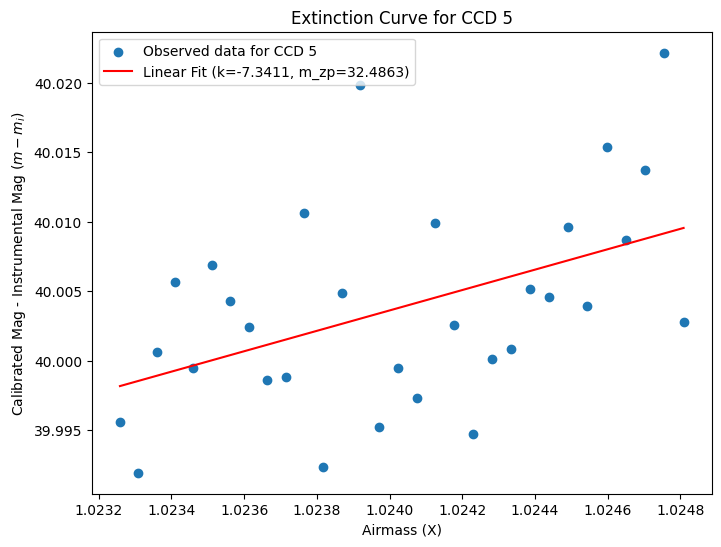

In [6]:
import numpy as np
import astropy.units as u
from astropy import time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
import hipercam as hcam
import matplotlib.pyplot as plt

lat = 28.7561 * u.deg
lon = -17.8917 * u.deg
height = 2267 * u.m
gtc_location = EarthLocation(lat=lat, lon=lon, height=height)

hlogss = hcam.hlog.Hlog.rascii('ss1.log')

# Calibrated magnitudes for each CCD
aboveatmosmag_per_ccd = [14.028, 13.805, 13.856, 13.995, 14.168]
standard_star_aperture_label = '1'
ccd_labels = sorted(hlogss.apnames.keys())

# Iterate through each CCD and its corresponding calibrated magnitude
for ccd_idx, ccd_label in enumerate(ccd_labels):

    # Lists to store data for the current CCD
    current_ccd_instrumental_mags = []
    current_ccd_airmass_values = []

    # Get the Tseries for the current CCD and specified aperture
    standard_star_tseries = hlogss.tseries(ccd_label, standard_star_aperture_label)

    # Extract data from the Tseries object
    counts_data = standard_star_tseries.y
    exposure_times_data = standard_star_tseries.te
    observation_mjd_times_data = standard_star_tseries.t

    # Loop through each observation to gather data
    for j in range(len(counts_data)):
        count = counts_data[j]
        exp_time = exposure_times_data[j]
        obs_mjd_time = observation_mjd_times_data[j]

        insmag = -2.5 * np.log10(count / exp_time)

        # Calculate airmass for the current observation
        times = time.Time(obs_mjd_time, format='mjd', scale='utc')
        SS_coords = SkyCoord('16:28:25.0', '+36:46:15', unit=(u.hourangle, u.deg), frame='icrs')
        altaz_frame = AltAz(obstime=times, location=gtc_location)
        SS_in_altaz = SS_coords.transform_to(altaz_frame)
        airmass = SS_in_altaz.secz

        # Store values for linear regression
        current_ccd_instrumental_mags.append(insmag)
        current_ccd_airmass_values.append(airmass.value)

    # Convert lists to numpy arrays for the current CCD
    current_ccd_instrumental_mags = np.array(current_ccd_instrumental_mags)
    current_ccd_airmass_values = np.array(current_ccd_airmass_values)

    # Perform linear regression: (m - m_i) = (-k * X) + m_zp
    delta_m_fit = aboveatmosmag_per_ccd[ccd_idx] - current_ccd_instrumental_mags
    coefficients = np.polyfit(current_ccd_airmass_values, delta_m_fit, 1)

    slope = coefficients[0]
    intercept = coefficients[1]

    k = -slope      
    m_zp = intercept 

    print(f"\n--- Results for CCD '{ccd_label}' (Aperture '{standard_star_aperture_label}') ---")
    print(f"Extinction coefficient (k): {k:.4f}")
    print(f"Zero point (m_zp): {m_zp:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(current_ccd_airmass_values, delta_m_fit, label=f'Observed data for CCD {ccd_label}')
    
    fit_line = slope * current_ccd_airmass_values + intercept
    plt.plot(current_ccd_airmass_values, fit_line, color='red', label=f'Linear Fit (k={k:.4f}, m_zp={m_zp:.4f})')
    
    plt.xlabel('Airmass (X)')
    plt.ylabel('Calibrated Mag - Instrumental Mag ($m - m_i$)')
    plt.title(f'Extinction Curve for CCD {ccd_label}')
    plt.legend()
    plt.show()